In [7]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd
from eofs.xarray import Eof

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

import pickle
import joblib

In [8]:
# return monthly average and regional longitude, latitude
# extract and group each month data
# after calculate the anomaly, remove the outliers
def month_data_slp(anom, month):
    month_group = anom.groupby("time.month").groups # group into seasons, use groups to read each group
    month_index = month_group[month]
    month_anom = anom[month_index,:,:]
    #### THE THRESHOLD????
    #month_anom = xr.where((month_anom>5), 0, month_anom)
    return month_anom


# calculate normalized anomalies -- CESM
# climatology based on 1976 to 2005 
def nor_anom(dataset):
    ds_clm = dataset.sel(time=slice("1976", "2005")).load()
    #lons_xr = dataset['lon'] # from -12W to 36E
    #lats_xr = dataset['lat'] # from 35N to 73N
    rr_clm = ds_clm

    gb_clm = rr_clm.groupby("time.month") # gb_clm: grouped data into 12 month for climatology
    gb = dataset.groupby("time.month")
    anom = ((gb - gb_clm.mean(dim="time")).groupby("time.month"))/gb_clm.std(dim="time") # normalized
    # important to add two times groupby
    # gb.mean: only 12 month -- average daily prcp at each month
    # prcp_anom -- each month one anomaly
    return anom

In [9]:
def data_load_cesm_slp(fn, start, end): # 'TP' 'NA' 'MD'
    ds_xr = xr.open_dataset(fn, chunks={"time": 10})
    ds_xr = ds_xr.sel(time=slice(start, end)).load()
    # convert 0-360 to -180-180
    #ds_xr = ds_xr.assign_coords(lon=(((ds_xr.lon + 180) % 360) - 180))
    # How to extract the desired region? -- by calculation
    reg_lon_xr = ds_xr['lon'] # from -40.375W to 75.375E
    reg_lat_xr = ds_xr['lat'] # from 25.375N to 75.375N
    temp_xr = ds_xr['PSL']
    # lat: -20 to 90; lon: -90W to 90E
    #xr1 = temp_xr[:,75:,:73].combine_first(temp_xr[:,75:,216:])
    xr1 = xr.concat([temp_xr[:,75:,216:], temp_xr[:,75:,:73]], dim="lon")
    # prec_xr = prec_xr1*1000*86400 # from m/s to mm/day
    # time, lat, lon
    return xr1, reg_lat_xr, reg_lon_xr

In [10]:
import os
path = r'C:/Users/yzh086/OneDrive - University of Bergen/PhD_lit/PhD_lit/task1/Data/CESM1/slp'
filelist = os.listdir(path)

pathlist = []
for i in range(len(filelist)):
    temp = path + '/' + filelist[i]
    pathlist.append(temp)
    
fn1 = pathlist[0]
# take the right time
temp_xr = xr.open_dataset(fn1, chunks={"time": 10})
### only ensemble 1 have 192001 ###
temp_xr = temp_xr.sel(time=slice('192001', '200512')).load() # be aware of the time here!!!

In [11]:
# preprocess SST -- all data together
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## change parameter for different region ##
#region = 'TP'

fn1 = pathlist[0]
# take the right time
temp_xr = xr.open_dataset(fn1, chunks={"time": 10})
### only ensemble 1 have 192001 ###
temp_xr = temp_xr.sel(time=slice('192001', '200512')).load() # be aware of the time here!!!

slp_xr, reg_lat_xr, reg_lon_xr = data_load_cesm_slp(fn1, '192002', '200601')

In [172]:
slp_xr[:,42:106,:105]

<xarray.DataArray 'PSL' (time: 1032, lat: 64, lon: 105)>
array([[[101606.93 , 101618.67 , 101604.84 , ..., 101499.805,
         101437.44 , 101298.95 ],
        [101652.59 , 101648.625, 101648.88 , ..., 101549.36 ,
         101465.94 , 101470.17 ],
        [101708.63 , 101696.086, 101690.55 , ..., 101578.75 ,
         101506.04 , 101538.28 ],
        ...,
        [101478.516, 101454.57 , 101422.58 , ..., 100035.16 ,
         100062.86 , 100090.25 ],
        [101506.016, 101487.914, 101454.836, ..., 100145.695,
         100168.52 , 100192.13 ],
        [101515.73 , 101503.95 , 101490.87 , ..., 100266.414,
         100286.56 , 100307.95 ]],

       [[101845.586, 101864.14 , 101846.52 , ..., 101583.28 ,
         101529.484, 101378.945],
        [101910.03 , 101900.055, 101891.086, ..., 101632.22 ,
         101550.64 , 101542.586],
        [101972.266, 101953.77 , 101932.44 , ..., 101650.516,
         101579.83 , 101573.625],
...
        [101239.266, 101223.13 , 101194.7  , ..., 100054.65 ,
         100084.01 , 100114.016],
        [101297.17 , 101277.74 , 101243.63 , ..., 100218.84 ,
         100245.22 , 100273.11 ],
        [101320.836, 101304.41 , 101288.48 , ..., 100431.016,
         100453.72 , 100477.44 ]],

       [[101883.695, 101849.586, 101799.73 , ..., 101646.375,
         101591.43 , 101508.84 ],
        [101919.27 , 101875.586, 101832.88 , ..., 101680.74 ,
         101631.33 , 101666.664],
        [101954.94 , 101904.86 , 101856.29 , ..., 101708.66 ,
         101669.2  , 101769.87 ],
        ...,
        [101069.04 , 101041.42 , 100998.1  , ..., 100308.52 ,
         100309.195, 100310.65 ],
        [101110.766, 101082.02 , 101036.   , ..., 100458.07 ,
         100463.86 , 100469.08 ],
        [101128.25 , 101105.09 , 101082.37 , ..., 100584.586,
         100591.89 , 100599.77 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 20.26 21.2 22.15 23.09 ... 76.81 77.75 78.69 79.63
  * lon      (lon) float64 270.0 271.2 272.5 273.8 ... 36.25 37.5 38.75 40.0
  * time     (time) object 1920-02-01 00:00:00 ... 2006-01-01 00:00:00
Attributes:
    units:         Pa
    long_name:     Sea level pressure
    cell_methods:  time: mean

In [13]:
# calculate anomaly
slp_anom = nor_anom(slp_xr[:,42:106,:105])

# detrend the time series at each grid point
#slp_danom = detrend_dim(slp_anom, 'time', deg=1)

# extract and group each season data
#anom_ensemble = sst_anom
anom_original = slp_anom

data = slp_anom.values # remove dimension = 1
time = temp_xr.time
lat = slp_anom.lat
lon = slp_anom.lon
anom_ensemble = xr.DataArray(data, 
                    coords=[time,lat,lon],  # format for multiple dimensions
                    dims=['time', 'lat', 'lon'])

In [174]:
anom_ensemble

<xarray.DataArray (time: 1032, lat: 64, lon: 105)>
array([[[-0.88285786, -0.8265013 , -0.83451056, ..., -1.5905304 ,
         -1.7860459 , -2.1479907 ],
        [-0.8929132 , -0.87023735, -0.79852176, ..., -1.5011867 ,
         -1.7005388 , -2.095662  ],
        [-0.84414667, -0.8481128 , -0.79288167, ..., -1.4254831 ,
         -1.5363922 , -1.9326162 ],
        ...,
        [-0.157868  , -0.16688064, -0.16218874, ..., -0.7581854 ,
         -0.7430764 , -0.7288959 ],
        [-0.13718721, -0.14420216, -0.15138127, ..., -0.71152973,
         -0.70035344, -0.6881641 ],
        [-0.09841304, -0.10608928, -0.12418765, ..., -0.6499196 ,
         -0.6385983 , -0.62640035]],

       [[ 1.1621108 ,  1.265984  ,  1.2403334 , ...,  0.4664375 ,
          0.4516111 ,  0.357076  ],
        [ 1.1970836 ,  1.2336775 ,  1.2362791 , ...,  0.52639586,
          0.4943962 ,  0.41559148],
        [ 1.2105366 ,  1.2248554 ,  1.2014737 , ...,  0.5434656 ,
          0.5889559 ,  0.23263235],
...
        [-0.10335127, -0.11603203, -0.12583776, ..., -0.97956455,
         -0.9432909 , -0.9063542 ],
        [-0.02412595, -0.04057024, -0.06447139, ..., -0.82676953,
         -0.79386854, -0.7584094 ],
        [ 0.08283907,  0.05455628,  0.01450943, ..., -0.59274316,
         -0.5619536 , -0.5301131 ]],

       [[ 1.9490751 ,  1.9492579 ,  1.9805453 , ...,  0.66670185,
          0.70357525,  0.8811126 ],
        [ 1.8928019 ,  1.8406792 ,  1.8193974 , ...,  0.61874914,
          0.7758752 ,  0.75282574],
        [ 1.7772719 ,  1.7003438 ,  1.596458  , ...,  0.6162448 ,
          0.7588318 ,  0.96250904],
        ...,
        [-0.50558805, -0.5237901 , -0.541189  , ..., -0.5524468 ,
         -0.56990963, -0.5869245 ],
        [-0.450276  , -0.47647926, -0.50863093, ..., -0.46222296,
         -0.47106573, -0.48105648],
        [-0.3914758 , -0.42107075, -0.4553971 , ..., -0.3981064 ,
         -0.4013249 , -0.40422127]]], dtype=float32)
Coordinates:
  * time     (time) object 1920-01-01 00:00:00 ... 2005-12-01 00:00:00
  * lat      (lat) float64 20.26 21.2 22.15 23.09 ... 76.81 77.75 78.69 79.63
  * lon      (lon) float64 270.0 271.2 272.5 273.8 ... 36.25 37.5 38.75 40.0

In [14]:
##### ensemble #####
for i in range(1,len(filelist)):

    fn1 = pathlist[i]
    slp_xr, reg_lat_xr, reg_lon_xr = data_load_cesm_slp(fn1, '192002', '200601')

    # total precipitation -- prect mm/day
    #prect_xr = precl_xr + precc_xr

    # calculate anomaly
    slp_anom = nor_anom(slp_xr[:,42:106,:105])

    # detrend the time series at each grid point
    #slp_danom = detrend_dim(slp_anom, 'time', deg=1)
    
    #if np.array_equal(anom_original.lat, slp_danom.lat) == False: # check if two array is exactly the same
    data = slp_anom.values # remove dimension = 1
    time = temp_xr.time
    lat = anom_original.lat
    lon = anom_original.lon
    anom_gb_temp = xr.DataArray(data, 
                        coords=[time, lat,lon], 
                        dims=['time', 'lat', 'lon'])

    anom_ensemble = xr.concat([anom_ensemble,anom_gb_temp], dim='time')

In [16]:
### save and load as netcdf ###
anom_ensemble.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\ensemble_data\slp\slp_nao.nc'
                        )

In [17]:
ensemble = anom_ensemble

In [ ]:
### save and load as netcdf ###
ensemble = xr.open_dataset(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sic_%s.nc'
                        % region)

ensemble = ensemble.__xarray_dataarray_variable__

In [ ]:
time = ensemble.time
lat = ensemble.TLAT
lon = ensemble.TLON

ensemble_new = xr.DataArray(ensemble.values, 
                            coords={'time':time, 
                                      'TLAT':(("nlat", "nlon"), np.array(tlat)),
                                      'TLON':(("nlat", "nlon"), np.array(tlon))}, 
                        dims=['time', 'nlat', 'nlon'])

In [176]:
##### save the data -- no need to run the previous again #####

df = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\ensemble_data\slp\slp_nao.txt' 
          ,'wb')
pickle.dump(anom_ensemble, df)
df.close()

In [21]:
##### open the file for next use #####
df2 = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\ensemble_data\slp\slp_nao.txt' 
          ,'rb')
ensemble = pickle.load(df2)
df2.close()

TypeError: __new__() got an unexpected keyword argument 'dtype'

In [18]:
### ways to calculate irregular season ###
# select the region 20N-80N, 90W-40E 
nao_raw = ensemble
# find DJFM SEASONAL data
nao_all = nao_raw[nao_raw.time.dt.month.isin([12,1,2,3])] # select data of 12,1,2,3 month
# take the rolling series from 1921 to 2005
nao_rolling = nao_all[3:-1]
nao_mean1 = nao_rolling.rolling(time = 4).mean()
# DJFM mean value at each step 4
nao2 = nao_mean1[nao_mean1.time.dt.month == 3]
# DJFM mean at 1920
nao1 = nao_all[:3].mean(dim='time')
# reshape time to (1,)
time = nao_all[:3].time[2].values.reshape(1,)
lat = nao_all[:3][2].lat
lon = nao_all[:3][2].lon
nao1 = xr.DataArray(nao1.values.reshape(1,64,105),coords=[time,lat,lon],dims=('time', 'lat', 'lon'))
# concat two array
nao_series = xr.concat([nao1, nao2], dim="time")
# nao_series for EOF 86*40

In [21]:
nao_series

<xarray.DataArray (time: 3440, lat: 64, lon: 105)>
array([[[ 0.04775956,  0.12356976,  0.1239369 , ..., -0.22284062,
         -0.289258  , -0.44888067],
        [ 0.04714338,  0.08324697,  0.11866742, ..., -0.16894394,
         -0.22523068, -0.39676914],
        [ 0.06338052,  0.07955459,  0.11060647, ..., -0.13554451,
         -0.13487446, -0.3219712 ],
        ...,
        [-0.7841143 , -0.7780576 , -0.7688698 , ..., -1.1602197 ,
         -1.1442438 , -1.127441  ],
        [-0.7616845 , -0.76616174, -0.7714002 , ..., -1.1731572 ,
         -1.1564828 , -1.1407013 ],
        [-0.7612049 , -0.7610317 , -0.7594094 , ..., -1.1843768 ,
         -1.1665438 , -1.1486367 ]],

       [[ 0.69620025,  0.6796966 ,  0.56143373, ..., -1.106498  ,
         -0.96795654, -0.6676107 ],
        [ 0.74109155,  0.68480015,  0.5840053 , ..., -1.1299744 ,
         -0.9764979 , -0.8378579 ],
        [ 0.7679458 ,  0.72582734,  0.6193386 , ..., -1.1514199 ,
         -1.0598819 , -0.89939797],
...
        [-0.7938074 , -0.79560226, -0.8003964 , ...,  0.8282997 ,
          0.82855093,  0.8269311 ],
        [-0.7505109 , -0.74743867, -0.74593234, ...,  0.75924116,
          0.7592061 ,  0.75840294],
        [-0.6926222 , -0.69378257, -0.7066941 , ...,  0.68306637,
          0.68438077,  0.6846355 ]],

       [[-0.1697454 , -0.18917656, -0.20527054, ..., -0.6368822 ,
         -0.5993349 , -0.45083356],
        [-0.1133742 , -0.14919244, -0.175576  , ..., -0.6434697 ,
         -0.59780264, -0.35432085],
        [-0.06917694, -0.10682994, -0.14269629, ..., -0.62335956,
         -0.60331875, -0.21320704],
        ...,
        [ 0.08549824,  0.08840099,  0.08621961, ...,  0.21903563,
          0.2407727 ,  0.26121566],
        [ 0.12981123,  0.13952008,  0.1374253 , ...,  0.24940547,
          0.26762232,  0.28470507],
        [ 0.17565882,  0.18640673,  0.18161619, ...,  0.2820446 ,
          0.29710943,  0.31109947]]], dtype=float32)
Coordinates:
  * time     (time) object 1920-03-01 00:00:00 ... 2005-03-01 00:00:00
  * lat      (lat) float64 20.26 21.2 22.15 23.09 ... 76.81 77.75 78.69 79.63
  * lon      (lon) float64 270.0 271.2 272.5 273.8 ... 36.25 37.5 38.75 40.0

In [22]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
#meantlat = np.mean(ensemble.lat.values, axis = 1)
wgts   = np.cos(np.deg2rad(nao_series.lat.values))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(64, 1) ## depends on the shape of region

solver = Eof(nao_series[:], weights=wgts)

In [23]:
eof_en = solver.eofs(neofs=5)
pc_en  = solver.pcs(npcs=5, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

In [24]:
eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NAO\nao_eof.nc')
pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NAO\nao_pc.nc')
varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NAO\nao_var.nc')
lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NAO\nao_lam.nc')

In [143]:
eof_en

<xarray.DataArray 'eofs' (mode: 5, lat: 64, lon: 105)>
array([[[-1.74636813e-02, -1.85241361e-02, -1.90579176e-02, ...,
         -1.47417629e-02, -1.26764175e-02, -1.12136649e-02],
        [-1.75132664e-02, -1.83603291e-02, -1.91894869e-02, ...,
         -1.45076827e-02, -1.30801096e-02, -1.02469901e-02],
        [-1.79783343e-02, -1.87047843e-02, -1.94682555e-02, ...,
         -1.46653982e-02, -1.34991741e-02, -1.15396598e-02],
        ...,
        [ 3.21724289e-03,  3.24544380e-03,  3.25975413e-03, ...,
          3.80884768e-03,  3.77975460e-03,  3.75077469e-03],
        [ 2.98522494e-03,  3.01216023e-03,  3.03552800e-03, ...,
          3.45136187e-03,  3.42742924e-03,  3.40263576e-03],
        [ 2.72403840e-03,  2.75390653e-03,  2.77987503e-03, ...,
          3.09427375e-03,  3.07434567e-03,  3.05424988e-03]],

       [[-2.02047610e-02, -2.07338983e-02, -2.09559112e-02, ...,
          2.72526819e-02,  2.57903375e-02,  2.18718121e-02],
        [-2.04576094e-02, -2.08015377e-02, -2.10731242e-02, ...,
          2.75349900e-02,  2.51463582e-02,  2.33741021e-02],
        [-2.08372046e-02, -2.11479669e-02, -2.12991692e-02, ...,
          2.68221538e-02,  2.52179796e-02,  2.10718759e-02],
...
        [-1.04114397e-05,  1.53873232e-05,  1.94863556e-05, ...,
          5.06281334e-04,  4.82292594e-04,  4.57752978e-04],
        [ 8.12606734e-06,  4.47527864e-05,  6.58408300e-05, ...,
          3.03687975e-04,  2.87975782e-04,  2.70620729e-04],
        [ 4.46301190e-05,  7.04723831e-05,  7.54382470e-05, ...,
          1.46151593e-04,  1.36904647e-04,  1.26550351e-04]],

       [[-1.10216697e-03, -7.48581375e-04, -1.01147091e-03, ...,
          1.16175710e-02,  1.16933743e-02,  1.33699222e-02],
        [-1.10864113e-03, -7.62240999e-04, -7.11688943e-04, ...,
          1.09373450e-02,  1.19620595e-02,  1.24631933e-02],
        [-1.03566986e-03, -7.95534178e-04, -4.69608638e-04, ...,
          1.11651864e-02,  1.16365206e-02,  1.38664104e-02],
        ...,
        [ 9.25799040e-03,  9.30864587e-03,  9.35834827e-03, ...,
          2.48534703e-03,  2.37462755e-03,  2.26644438e-03],
        [ 8.35726873e-03,  8.38562903e-03,  8.44216445e-03, ...,
          2.54361001e-03,  2.44467756e-03,  2.34704907e-03],
        [ 7.40480528e-03,  7.44511337e-03,  7.52526259e-03, ...,
          2.52143878e-03,  2.42957405e-03,  2.34090685e-03]]])
Coordinates:
  * mode     (mode) int32 0 1 2 3 4
  * lat      (lat) float64 20.26 21.2 22.15 23.09 ... 76.81 77.75 78.69 79.63
  * lon      (lon) float64 270.0 271.2 272.5 273.8 ... 36.25 37.5 38.75 40.0
Attributes:
    long_name:  empirical_orthogonal_functions

In [13]:
##### save data #####
import joblib
joblib.dump(eof_en, r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\nao_eof.pkl' 
            ,compress=9)
joblib.dump(pc_en, r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\nao_pc.pkl'
            ,compress=9)
joblib.dump(varfrac_en, r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\nao_varfrac.pkl'
            ,compress=9)
joblib.dump(lambdas_en, r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\nao_lambdas.pkl'
            ,compress=9)

['C:\\Users\\yzh086\\OneDrive - University of Bergen\\PhD_lit\\PhD_lit\\task1\\processed_data\\nao_lambdas.pkl']

In [20]:
joblib.load(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NAO\nao_pc.pkl')

TypeError: __new__() got an unexpected keyword argument 'dtype'

In [12]:
import pickle
#df2 = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NAO\nao_eof.pkl'
            ,'rb')
#pc_en = pickle.load(df2)
df2.close()


#eof_en = pickle.load(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NAO\nao_eof.pkl'
                    #,'rb')
#pc_en = pickle.load(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NAO\nao_pc.pkl'
                   #,'rb')

UnpicklingError: invalid load key, 'x'.

In [11]:
pc_en

NameError: name 'pc_en' is not defined

In [183]:
### re-apply for new coordinate since it is not equally placed ###
### this should be changed by different region ###
new_long = np.linspace(-90,40,105) # 110 E to 75 W
new_lat = np.linspace(20,80,64) # -20 to 20

RuntimeError: Cannot handle non-rectangular coordinate systems.

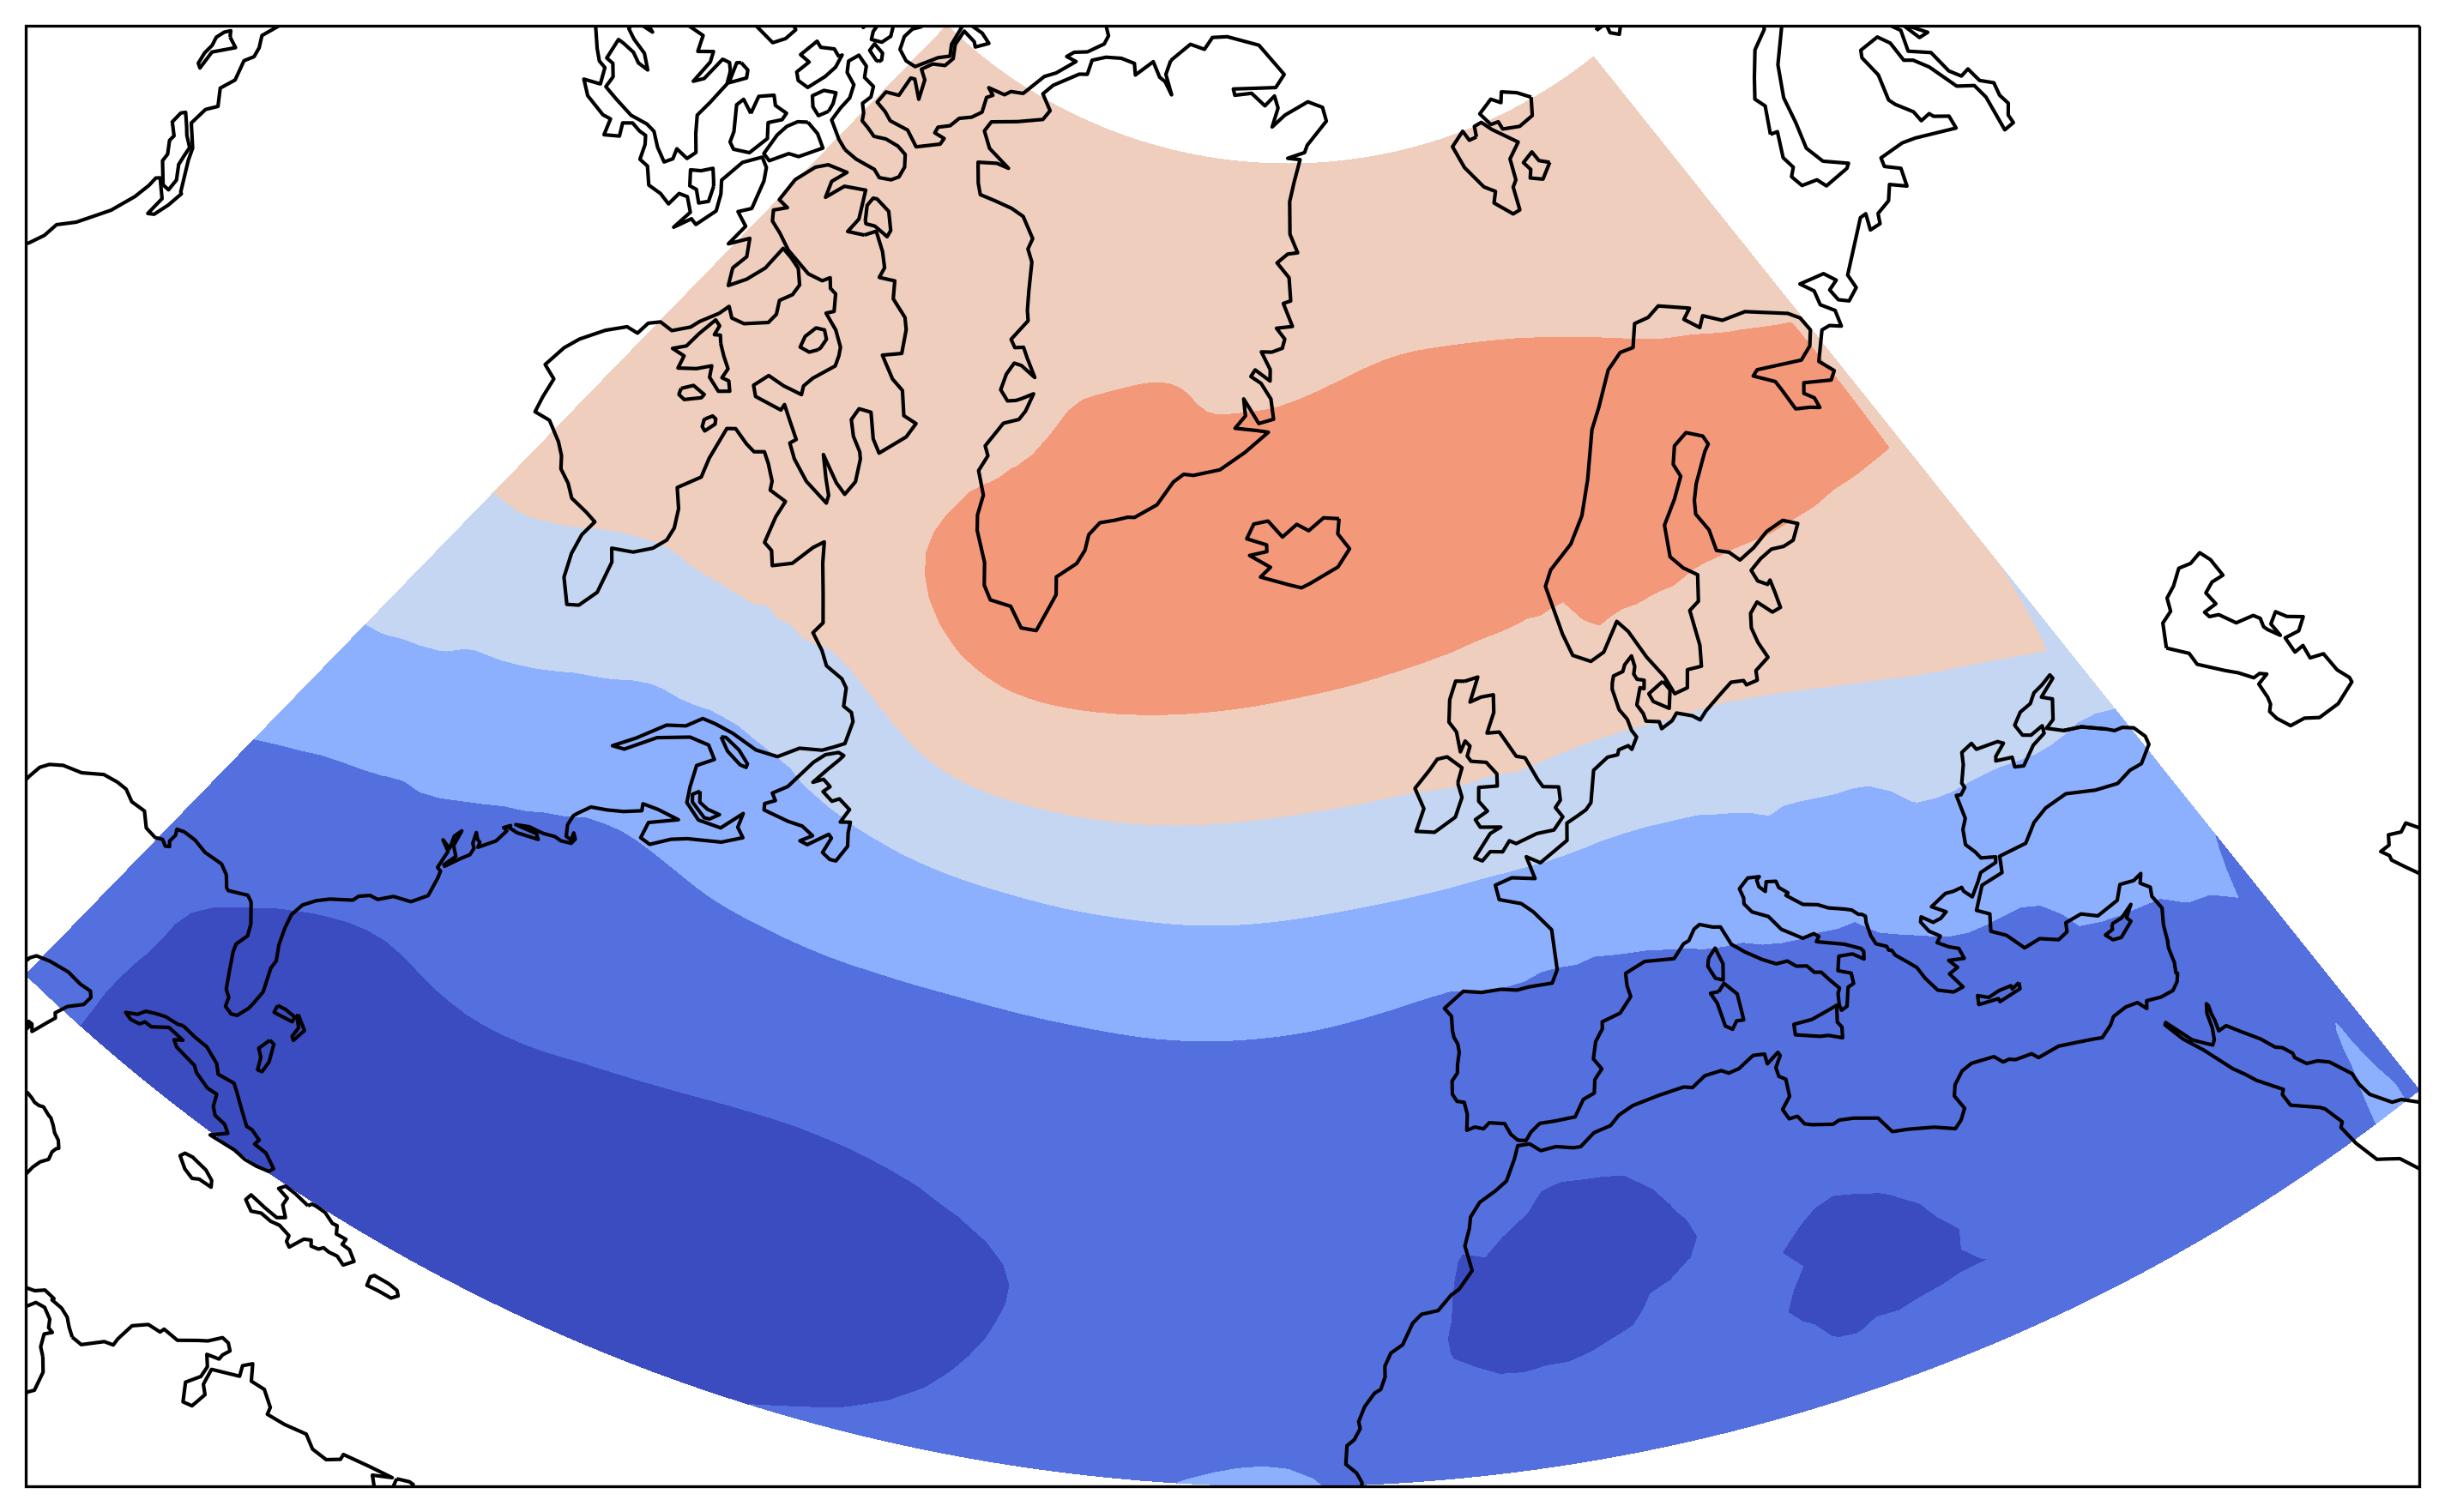

In [189]:
##### finally plot #####

#fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),dpi =300)
# if on the west sphere, change the central longitude
proj = ccrs.LambertConformal(central_longitude=-20, central_latitude=60)
#ax = plt.axes(projection=proj)

#fig, ax = plt.subplots(1,1, figsize=(12,12), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)),dpi =300)
fig, ax = plt.subplots(1,1, figsize=(12,12), subplot_kw=dict(projection=proj),dpi =300)

fig = plt.gcf()

#title1 = '%s_cluster' % (season)

#for ax, i in zip(axs.ravel(), range(1)):

title2 = 'EOF%s(%s%%)' % (1, int(varfrac_en[0]*100))
# tim
data = eof_en[0]
# Add cyclic point to data
#data=mean_anom_djf_cluster1
data, lons = add_cyclic_point(data, coord=new_long)
lat = new_lat
# Make a filled contour plot
# Add coastlines
ax.coastlines()

# mask the LAND part with white color
#ax.add_feature(cart.feature.LAND, facecolor = 'white', zorder=200, edgecolor='k')

cs=ax.contourf(lons, new_lat, data,
            transform = ccrs.PlateCarree(),cmap='coolwarm',levels = np.linspace(-0.02,0.02,7),
               extend='both') # (lat, lon)

# Define the xticks for longitude

ax.set_xticks(np.arange(-90,40,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
#plt.title(title2, fontsize = 18)
ax.set_title(title2, fontsize = 22)

ax.set_yticks(np.arange(20,80,5), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.1, top = 0.95, hspace =0.2, wspace=.005)    

# Add colorbar
bar_cax = plt.axes([0.05, 0.05, 0.9,0.02]) # left&right, bottom, size, size
#plt.colorbar(cax=cax)
#cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar.ax.tick_params(labelsize = 15)
    
    
#fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\eof\sst\tp\eof_slp_test.png')

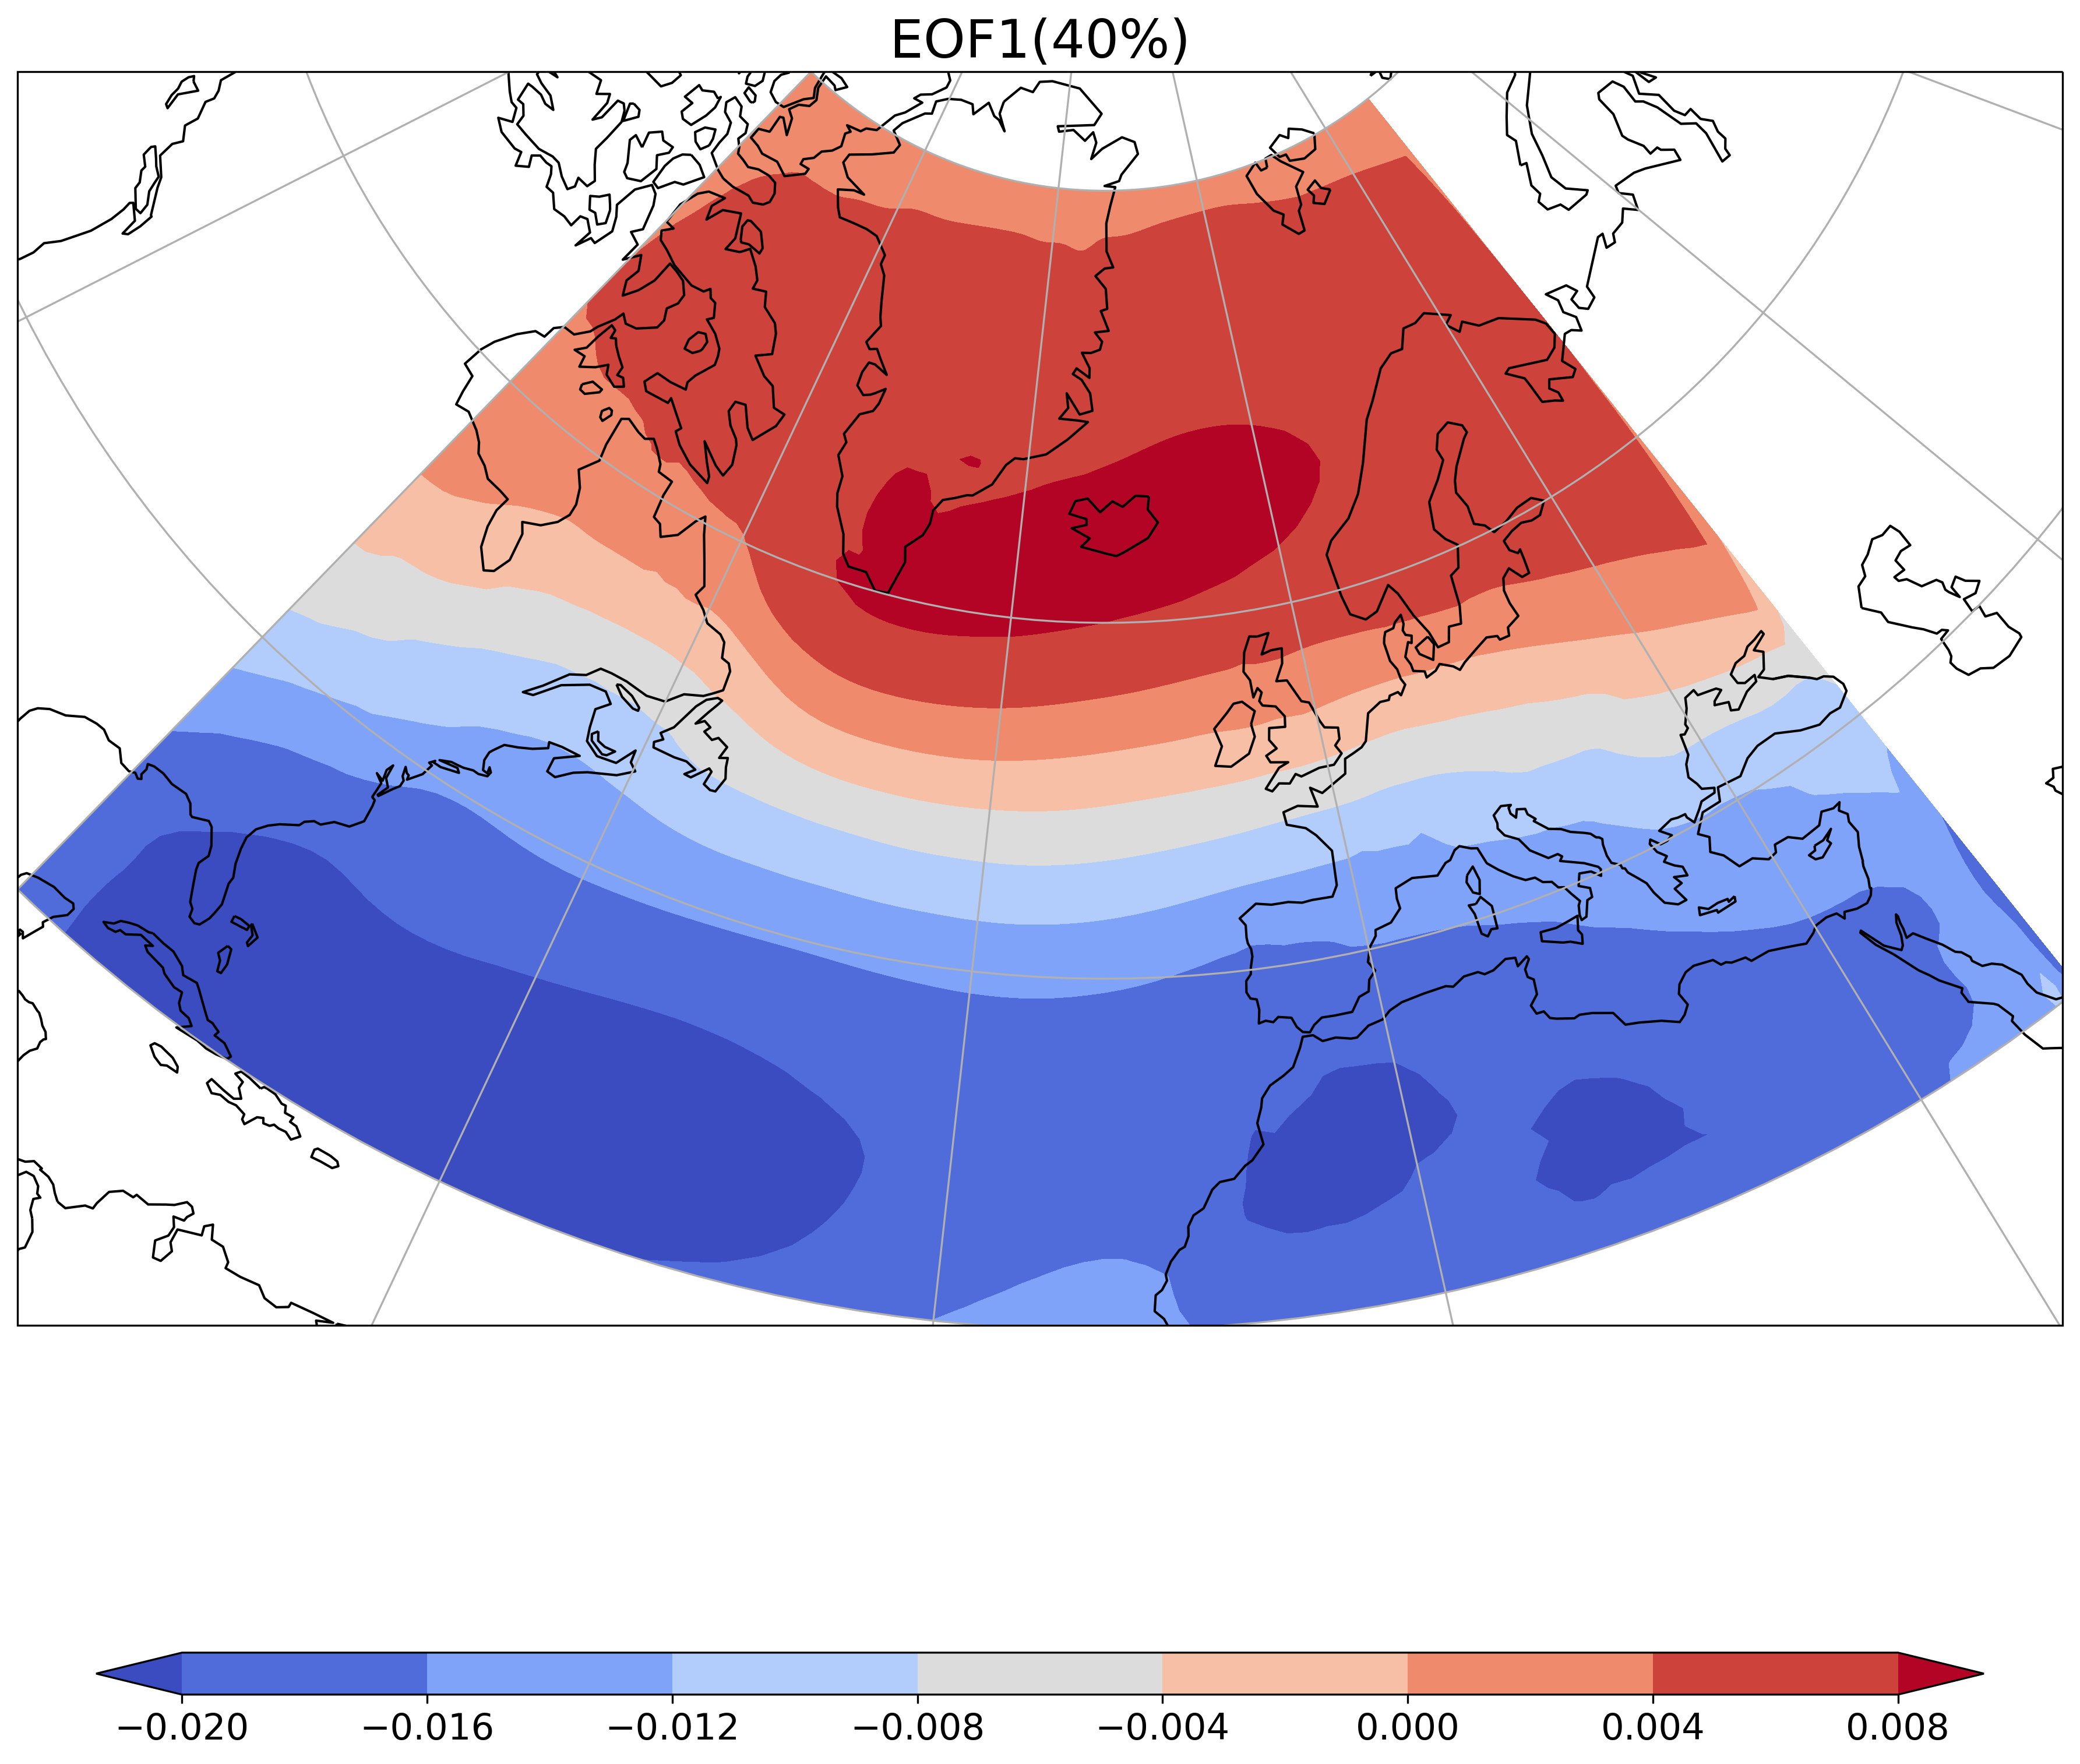

In [190]:
##### finally plot #####
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import shapely.geometry as sgeom
#fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),dpi =300)
# if on the west sphere, change the central longitude
#proj = ccrs.Orthographic(central_longitude=-20, central_latitude=60)
#ax = plt.axes(projection=proj)

proj = ccrs.LambertConformal(central_longitude=-20, central_latitude=60)
#fig, ax = plt.subplots(1,1, figsize=(12,12), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)),dpi =300)
fig, ax = plt.subplots(1,1, figsize=(12,12), subplot_kw=dict(projection=proj),dpi =300)

fig = plt.gcf()

#title1 = '%s_cluster' % (season)

#for ax, i in zip(axs.ravel(), range(1)):

title2 = 'EOF%s(%s%%)' % (1, int(varfrac_en[0]*100))
# tim
data = eof_en[0]
# Add cyclic point to data
#data=mean_anom_djf_cluster1
data, lons = add_cyclic_point(data, coord=new_long)
lat = new_lat
# Make a filled contour plot
# Add coastlines
ax.coastlines()

# mask the LAND part with white color
#ax.add_feature(cart.feature.LAND, facecolor = 'white', zorder=200, edgecolor='k')

cs=ax.contourf(lons, new_lat, data,
            transform = ccrs.PlateCarree(),cmap='coolwarm',#levels = np.linspace(-0.02,0.02,7),
               extend='both') # (lat, lon)

# Define the xticks for longitude
ax.set_extent((-90,40,20,80), crs = ccrs.PlateCarree())

# Define gridline locations and draw the lines using cartopy's built-in gridliner:
#long = np.arange(-180,180,30) # 110 E to 75 W
#lat = np.arange(20,90,10) # -20 to 20
#ax.gridlines(xlocs=lat, ylocs=long)

# Label the end-points of the gridlines using the custom tick makers:
ax.gridlines()

#ax.set_xticks(np.arange(-180,180,30), crs=ccrs.PlateCarree())
#lon_formatter = cticker.LongitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
#plt.title(title2, fontsize = 18)
ax.set_title(title2, fontsize = 22)

#ax.set_yticks(np.arange(20,90,10), crs=ccrs.PlateCarree())
#lat_formatter = cticker.LatitudeFormatter()
#ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.1, top = 0.95, hspace =0.2, wspace=.005)    

# Add colorbar
bar_cax = plt.axes([0.05, 0.05, 0.9,0.02]) # left&right, bottom, size, size
#plt.colorbar(cax=cax)
#cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar.ax.tick_params(labelsize = 15)

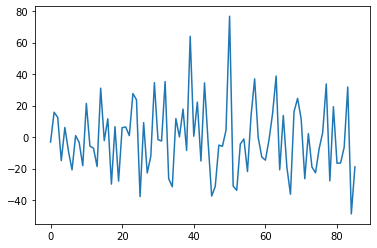

In [163]:
plt.plot(pc_en[:86,0])

In [162]:
pc_en.shape

(3440, 5)